# kNNClassifier

## Importing Packages

In [1]:
from mlots import kNNClassifier
from sklearn.model_selection import GridSearchCV
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline

In [2]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

## Loading Data

Here we are loading the ``PickupGestureWiimoteZ`` dataset.  
The datasets are in two ``.arff`` files with pre-defined train and test splits.  
The following code reads the two files stores the ``X`` (time-series data) and ``y`` (labels), into their specific train and test sets.
***

In [13]:
name = "PickupGestureWiimoteZ"

dataset = arff.loadarff(f'../input/{name}/{name}_TRAIN.arff'.format(name=name))[0]
X_train = np.array(dataset.tolist(), dtype=np.float32)
y_train = X_train[: , -1]
X_train = X_train[:, :-1]

dataset = arff.loadarff(f'../input/{name}/{name}_TEST.arff'.format(name=name))[0]
X_test = np.array(dataset.tolist(), dtype=np.float32)
y_test = X_test[: , -1]
X_test = X_test[:, :-1]

#Converting target from bytes to integer
y_train = [int.from_bytes(el, "little") for el in y_train]
y_test = [int.from_bytes(el, "little") for el in y_test]
X_train.shape, X_test.shape

((50, 361), (50, 361))

|Set|Sample size|TS length|
|:---|:----------|:-------|
|Train|50|361|
|Test|50|361|

## Evaluating kNNClassifier

### Default parameters

We would employ ``kNNClassifier`` model from the ``mlots`` python package.  
First, the model is evaluated with default parameters over the ``PickupGestureWiimoteZ`` dataset.
***

In [15]:
model_default = kNNClassifier().fit(X_train,y_train)

In [16]:
y_hat_default = model_default.predict(X_test)
acc_default = accuracy_score(y_test, y_hat_default)
print("Model accuracy with default parameters: ", round(acc_default, 2)*100)

Model accuracy with default parameters:  60.0


The accuracy of the model is **60\%**, which is better than random guessing. However, lets try tuning the model's parameter now.

### Model tuning

``kNNClassifier`` model allows us to work with a more complex distance measure like ``DTW`` in a ``MAC/FAC`` strategy.  
Here, we would use ``GridSearchCV`` algorithm from the ``sklearn`` package to find the best set of parameters of the model over the dataset.  
The model tuning would be done **only** over the ``train`` set of the dataset.
***

In [17]:
#Setting up the warping window grid of the DTW measure

dtw_params = []
for w_win in range(5,30,3):
    dtw_params.append(
    {
        "global_constraint": "sakoe_chiba",
        "sakoe_chiba_radius": w_win
    }
    )
dtw_params

[{'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 8},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 11},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 14},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 17},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 20},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 23},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 26},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 29}]

In [18]:
#Setting up the param grid for the kNNClassifier model with the DTW params

param_grid = {
    "n_neighbors": np.arange(1,12,2),
    "metric_params" : dtw_params
}
param_grid

{'n_neighbors': array([ 1,  3,  5,  7,  9, 11]),
 'metric_params': [{'global_constraint': 'sakoe_chiba',
   'sakoe_chiba_radius': 5},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 8},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 11},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 14},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 17},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 20},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 23},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 26},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 29}]}

In [19]:
#Executing the GridSearchCv over the kNNClassifier model with the supplied param_grid.

model = kNNClassifier(mac_metric="dtw")
gscv = GridSearchCV(model, param_grid=param_grid, cv=5,
                    scoring="accuracy", n_jobs=-1).fit(X_train,y_train)

In [24]:
#Displaying the best parameters of kNNClassifier within the search grid.

best_param = gscv.best_params_
best_score = gscv.best_score_
print("Best Parameters: ", best_param)
print("Best Accuracy: ", best_score)

Best Parameters:  {'metric_params': {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5}, 'n_neighbors': 1}
Best Accuracy:  0.62


### Evaluation of tuned model

The parameters displayed above are optimal set of parameters for the ``kNNClassifier`` model over ``PickupGestureWiimoteZ`` dataset.  
Our next task is then to train the ``kNNClassifier`` model over the ``train`` set with the optimal set of parameters, and evaluate the model over the held-out ``test`` set.
***

In [25]:
model_tuned = kNNClassifier(**best_param,mac_metric="dtw").fit(X_train,y_train)



In [26]:
y_hat_tuned = model_tuned.predict(X_test)
acc_tuned = accuracy_score(y_test, y_hat_tuned)
print("Model accuracy with tuned parameters: ", round(acc_tuned, 2))

Model accuracy with tuned parameters:  0.7


By tuning the parameters of the model we increased the accuracy of the model from $60\%$ to $70\%$.

## Comparison

Here we do bar-plot that would illustrate the performance of the ``kNNClassifier`` model with **default** parameters against the model with the **tuned** parameters.  
The ``matplotlib.pyplot`` is employed for this task.
***

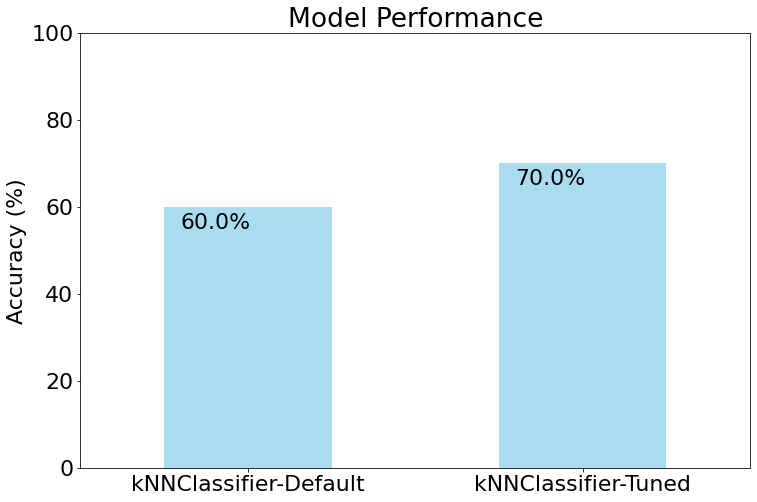

In [23]:
acc =  [acc_default*100,acc_tuned*100]
models = ["kNNClassifier-Default", "kNNClassifier-Tuned"]

df = pd.DataFrame({"models": models, "Accuracy":acc})

fig = plt.figure()
ax = df['Accuracy'].plot(kind="bar", figsize=(12, 8), alpha=0.7,
                 color=[
                     'skyblue'
                 ], label = "Accuracy")

ax.set_xticklabels(df['models'])
ax.set_ylabel("Accuracy (%)")

ax.set_ylim(0,100)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
for i,a in enumerate(acc):
    ax.text(i-0.2,a-5,str(round(a,3))+"%")
plt.text
plt.title("Model Performance")
plt.show()